#### Description
This code cleans the 2000 and 2021 CPIS and produces a color map of the percent CPIS per country in 2000 vs 2021

In [19]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap, Normalize
import os
import yaml
import unicodedata
import numpy as np



with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

def read(config_str):
    return pd.read_csv(resolve_path(config[config_str]))

def geo_read(config_str):
    return gpd.read_file(resolve_path(config[config_str]))

def normalize_text(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    ).lower()

non_ssa_countries = ['DZA', 'EGY', 'LBY', 'MAR', 'SDN', 'TUN', 'ESH']


Prep the 2000s Data for merging

In [20]:
# Load the shapefile for the arid regions
arid_shapefile = geo_read('Africa_All_shp_path')

Total_area_2000 = read('AQUA_AfricaIrrigation_2000')
CPIS_area_2000 = geo_read('Africa_CPIS_2000_shp_path')
print(CPIS_area_2000.crs)

# rename the columns to match CPIS_area 
Total_area_2000.rename(columns={'Area': 'Country', 'Value': 'Area_1000ha'}, inplace=True)
CPIS_area_2000.rename(columns={'Country Co': 'ISO'}, inplace = True)

# Add area in terms of hectares
CPIS_area_2000['Area_1000ha'] = CPIS_area_2000['Area_m2'] / 10000000

# drop unncessary columns
Total_area_2000.drop(columns=['VariableGroup', 'Subgroup', 'Variable', 'Unit', 'Symbol', 'IsAggregate'], inplace = True)
CPIS_area_2000.drop(columns=['Id', 'Area_m2'], inplace = True)

# reorder/sort
CPIS_area_summed_2000 = CPIS_area_2000.groupby('ISO', as_index=False)['Area_1000ha'].sum()
CPIS_area_summed_2000['Year'] = 2000

# Save
CPIS_area_summed_2000.to_csv(resolve_path(config['CPIS_Area_by_Country_2000_path']))

# Drop the year column before merging
Total_area_2000.drop(columns=['Year'], inplace=True)
CPIS_area_summed_2000.drop(columns=['Year'], inplace=True)

EPSG:3857


Prep the 2021 data for merging

In [21]:
# Load the shapefile for the arid regions
arid_shapefile = geo_read('Africa_All_shp_path')

Total_area_2021 = read('AQUA_AfricaIrrigation_2021')
CPIS_area_2021 = geo_read('Africa_CPIS_2021_shp_path')
print(CPIS_area_2021.crs)

# rename the columns to match CPIS_area 
Total_area_2021.rename(columns={'Area': 'Country', 'Value': 'Area_1000ha'}, inplace=True)
CPIS_area_2021.rename(columns={'Country Co': 'ISO'}, inplace = True)

print(CPIS_area_2021['ISO'].unique())

# Add area in terms of hectares
CPIS_area_2021['Area_1000ha'] = CPIS_area_2021['Area_m2'] / 10000000

# drop unncessary columns
Total_area_2021.drop(columns=['VariableGroup', 'Subgroup', 'Variable', 'Unit', 'Symbol', 'IsAggregate'], inplace = True)
CPIS_area_2021.drop(columns=['Id', 'Area_m2'], inplace = True)

# reorder/sort
CPIS_area_summed_2021 = CPIS_area_2021.groupby('ISO', as_index=False)['Area_1000ha'].sum()
CPIS_area_summed_2021['Year'] = 2000

# Save
CPIS_area_summed_2021.to_csv(resolve_path(config['CPIS_Area_by_Country_2021_path']))

# Drop the year column before merging
Total_area_2021.drop(columns=['Year'], inplace=True)
CPIS_area_summed_2021.drop(columns=['Year'], inplace=True)



EPSG:3857
['ZAF' 'NAM' 'BWA' 'AGO' 'LSO' 'SWZ' 'MOZ' 'ZWE' 'MDG' 'ZMB' 'MWI' 'KEN'
 'TCD' 'NGA' 'GHA' 'BFA' 'GMB' 'MLI' 'SEN' 'MRT' 'LBY' 'DZA']


Merge the 2000 total and CP data

In [23]:
# Merge the total and CPIS data into the same dataframe
merged_data_2000 = Total_area_2000.merge(CPIS_area_summed_2000, how='left', on='ISO', suffixes=('_total', '_CPIS'))

# Add zeros for countries with no CPIS data
merged_data_2000['Area_1000ha_CPIS'] = merged_data_2000['Area_1000ha_CPIS'].fillna(0)

# Add column for the percent of irrigation that CPIS accounts for in each country
merged_data_2000['Percent_CPIS'] = (merged_data_2000['Area_1000ha_CPIS'] / merged_data_2000['Area_1000ha_total']) * 100

# Save
merged_data_2000.to_csv(resolve_path(config['Comp_by_Country_2000_csv_path']))


Merge the 2021 total and CP data

In [24]:
# Merge the total and CPIS data into the same dataframe
merged_data_2021 = Total_area_2021.merge(CPIS_area_summed_2021, how='left', on='ISO', suffixes=('_total', '_CPIS'))

# Add zeros for countries with no CPIS data
merged_data_2021['Area_1000ha_CPIS'] = merged_data_2021['Area_1000ha_CPIS'].fillna(0)

# Add column for the percent of irrigation that CPIS accounts for in each country
merged_data_2021['Percent_CPIS'] = (merged_data_2021['Area_1000ha_CPIS'] / merged_data_2021['Area_1000ha_total']) * 100

# Save
merged_data_2021.to_csv(resolve_path(config['Comp_by_Country_2021_csv_path']))


Merge CPIS data with africa boundaries shapefile

In [25]:
# Load the shapefile for Africa boundaries and CPIS
africa_boundaries = geo_read('Africa_boundaries_shp_path')

cpis_data_2000 = read('Comp_by_Country_2000_csv_path')
cpis_data_2021 = read('Comp_by_Country_2021_csv_path')

# Merge the shapefile GeoDataFrame with the CSV DataFrame
merged_geo_data_2000 = africa_boundaries.merge(cpis_data_2000, on='ISO', how='left')
merged_geo_data_2021 = africa_boundaries.merge(cpis_data_2021, on='ISO', how='left')
print(merged_geo_data_2000.head())
top_5_2021 = merged_geo_data_2021.nlargest(5, 'Percent_CPIS')[['ISO', 'Percent_CPIS']]
print(top_5_2021)

   OBJECTID  ISO                       NAME_0 Continent          REgion  \
0         1  AGO                       Angola    Africa            None   
1         2  ATF  French Southern Territories    Africa            None   
2         3  BDI                      Burundi    Africa  Eastern_Africa   
3         4  BEN                        Benin    Africa            None   
4         5  BFA                 Burkina Faso    Africa            None   

                                            geometry  Unnamed: 0  \
0  MULTIPOLYGON (((11.70236 -16.50764, 11.70236 -...         0.0   
1  MULTIPOLYGON (((68.86333 -50.01889, 68.86166 -...         NaN   
2  POLYGON ((30.41152 -2.31061, 30.41243 -2.31180...         4.0   
3  MULTIPOLYGON (((1.87042 6.28819, 1.87042 6.287...         1.0   
4  POLYGON ((-0.45567 15.08082, -0.44206 15.06812...         3.0   

        Country  Area_1000ha_total  Area_1000ha_CPIS  Percent_CPIS  
0        Angola          84.608333          0.137061      0.161995  
1 

Examine maximum percentages for each year

In [26]:
# Find the maximum value for each year and overall
max_2000 = merged_geo_data_2000['Percent_CPIS'].max()
max_2021 = merged_geo_data_2021['Percent_CPIS'].max()
max_value = max(max_2000, max_2021)

print(f'Maximum Percentage of CPIS in 2000: {max_2000:.2f}%')
print(f'Maximum Percentage of CPIS in 2021: {max_2021:.2f}%')

Maximum Percentage of CPIS in 2000: 29.13%
Maximum Percentage of CPIS in 2021: 111.01%


Map the percentages for each year

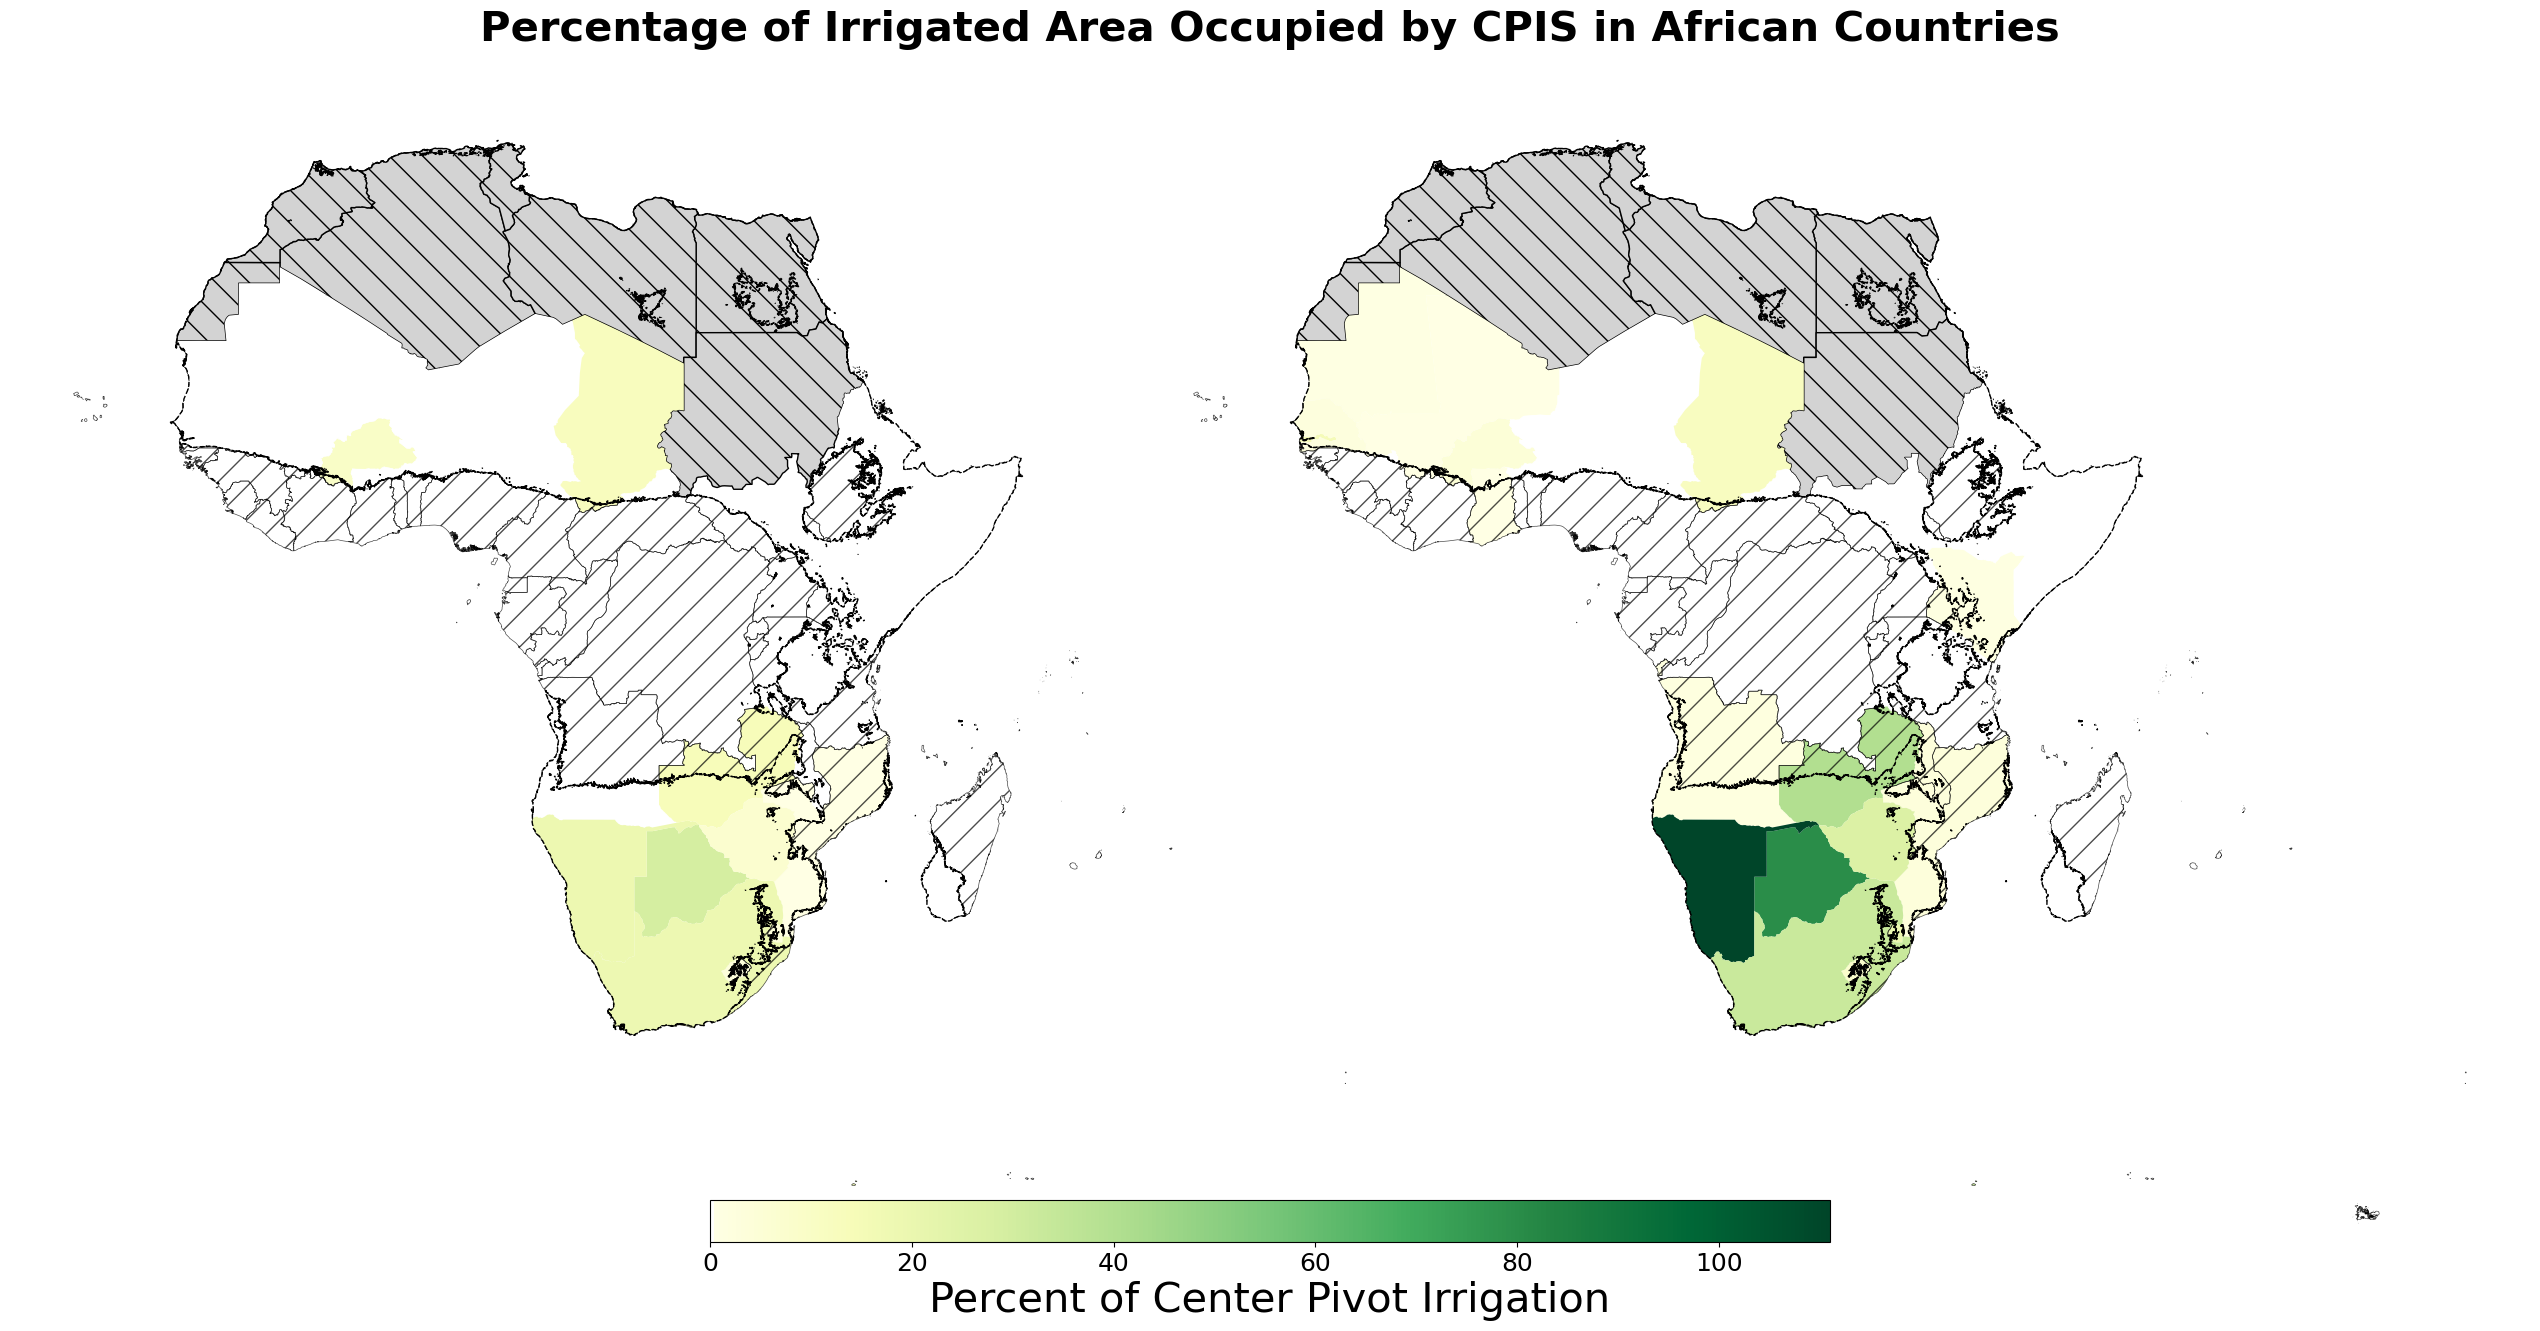

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize

# Load the shapefile for the arid regions
arid_shapefile = geo_read('Africa_All_shp_path')

# Simplify geometries to speed up plotting (apply to the geometry column only)
simplification_tolerance = 0.01
merged_geo_data_2000['geometry'] = merged_geo_data_2000['geometry'].simplify(simplification_tolerance)
merged_geo_data_2021['geometry'] = merged_geo_data_2021['geometry'].simplify(simplification_tolerance)
arid_shapefile['geometry'] = arid_shapefile['geometry'].simplify(simplification_tolerance)

# Custom colormap: white for zero values, viridis otherwise
viridis = plt.colormaps.get_cmap('YlGn')
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])  # RGBA for white
newcolors[0, :] = white  
custom_cmap = ListedColormap(newcolors)

# Create the plot with adjusted figure size to minimize whitespace
fig, ax = plt.subplots(1, 2, figsize=(28, 14), sharex=True, sharey=True)

# Adjust space between subplots and overall margins
plt.subplots_adjust(wspace=-0.2, hspace=0, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Plot the 2000 data
SSA_countries = merged_geo_data_2000[~merged_geo_data_2000['ISO'].isin(non_ssa_countries)]
non_SSA_countries = merged_geo_data_2000[merged_geo_data_2000['ISO'].isin(non_ssa_countries)]

# Plot non-SSA regions in grayscale with hatching
non_SSA_countries.plot(ax=ax[0], color='lightgray', edgecolor='black', hatch="\\")

# Plot SSA regions with CPIS data
SSA_countries.plot(column='Percent_CPIS', ax=ax[0], legend=False, 
                 cmap=custom_cmap, vmin=0, vmax=max_value)

# Calculate and plot non-arid regions within SSA with hatching
non_arid_regions = SSA_countries.overlay(arid_shapefile, how='difference')
non_arid_regions.plot(ax=ax[0], facecolor="none", edgecolor='black', hatch='/', linewidth=0.5, alpha=0.7)

# Plot the arid region outline
arid_shapefile.boundary.plot(ax=ax[0], edgecolor='black', linewidth=1, linestyle='--')

# Title the 2000 plot
#ax[0].set_title("2000", fontsize=25)
ax[0].set_axis_off()                 

# Plot the 2021 data
SSA_countries_2021 = merged_geo_data_2021[~merged_geo_data_2021['ISO'].isin(non_ssa_countries)]
non_SSA_countries_2021 = merged_geo_data_2021[merged_geo_data_2021['ISO'].isin(non_ssa_countries)]

# Plot non-SSA regions in grayscale with hatching
non_SSA_countries_2021.plot(ax=ax[1], color='lightgray', edgecolor='black', hatch="\\")

# Plot SSA regions with CPIS data
SSA_countries_2021.plot(column='Percent_CPIS', ax=ax[1], legend=False, 
                 cmap=custom_cmap, vmin=0, vmax=max_value)

# Calculate and plot non-arid regions within SSA with hatching
non_arid_regions_2021 = SSA_countries_2021.overlay(arid_shapefile, how='difference')
non_arid_regions_2021.plot(ax=ax[1], facecolor="none", edgecolor='black', hatch='/', linewidth=0.5, alpha=0.7)

# Plot the arid region outline
arid_shapefile.boundary.plot(ax=ax[1], edgecolor='black', linewidth=1, linestyle='--')

# Title the 2021 plot
#ax[1].set_title("2021", fontsize=25)
ax[1].set_axis_off()

# Add main title
fig.suptitle("Percentage of Irrigated Area Occupied by CPIS in African Countries", fontsize=30, fontweight='bold')

# Add legend
cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.03]) 
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=Normalize(vmin=0, vmax=max_value))
sm._A = []  # Trick to enable creation of a color bar
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Percent of Center Pivot Irrigation", fontsize=30)
cbar.ax.tick_params(labelsize=18)
plt.show()

